# US Flights Performance Analysis

In [ ]:
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import plotly.express as px
from dash import no_update


# Create a dash application
app = dash.Dash(__name__)

# REVIEW1: Clear the layout and do not display exception till callback gets executed
app.config.suppress_callback_exceptions = True

# Read the airline data into pandas dataframe
airline_data =  pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/airline_data.csv', 
                            encoding = "ISO-8859-1",
                            dtype={'Div1Airport': str, 'Div1TailNum': str, 
                                   'Div2Airport': str, 'Div2TailNum': str})


# List of years 
year_list = [i for i in range(2005, 2021, 1)]

"""Compute graph data for creating yearly airline performance report 

Function that takes airline data as input and create 5 dataframes based on the grouping condition to be used for plottling charts and grphs.

Argument:
     
    df: Filtered dataframe
    
Returns:
   Dataframes to create graph. 
"""
def compute_data_choice_1(df):
    # Cancellation Category Count
    bar_data = df.groupby(['Month','CancellationCode'])['Flights'].sum().reset_index()
    # Average flight time by reporting airline
    line_data = df.groupby(['Month','Reporting_Airline'])['AirTime'].mean().reset_index()
    # Diverted Airport Landings
    div_data = df[df['DivAirportLandings'] != 0.0]
    # Source state count
    map_data = df.groupby(['OriginState'])['Flights'].sum().reset_index()
    # Destination state count
    tree_data = df.groupby(['DestState', 'Reporting_Airline'])['Flights'].sum().reset_index()
    return bar_data, line_data, div_data, map_data, tree_data


"""Compute graph data for creating yearly airline delay report

This function takes in airline data and selected year as an input and performs computation for creating charts and plots.

Arguments:
    df: Input airline data.
    
Returns:
    Computed average dataframes for carrier delay, weather delay, NAS delay, security delay, and late aircraft delay.
"""
def compute_data_choice_2(df):
    # Compute delay averages
    avg_car = df.groupby(['Month','Reporting_Airline'])['CarrierDelay'].mean().reset_index()
    avg_weather = df.groupby(['Month','Reporting_Airline'])['WeatherDelay'].mean().reset_index()
    avg_NAS = df.groupby(['Month','Reporting_Airline'])['NASDelay'].mean().reset_index()
    avg_sec = df.groupby(['Month','Reporting_Airline'])['SecurityDelay'].mean().reset_index()
    avg_late = df.groupby(['Month','Reporting_Airline'])['LateAircraftDelay'].mean().reset_index()
    return avg_car, avg_weather, avg_NAS, avg_sec, avg_late


# Application layout
app.layout = html.Div(children=[ 
                                # TASK1: Add title to the dashboard
                                # Enter your code below. Make sure you have correct formatting.
                                html.H2('US Domestic Airline Flights Performance',style={'textAlign':'center','color':'#503d36','font-size':24}),
                                # REVIEW2: Dropdown creation
                                # Create an outer division 
                                html.Div([
                                    # Add an division
                                    html.Div([
                                        # Create an division for adding dropdown helper text for report type
                                        html.Div(
                                            [
                                            html.H2('Report Type:', style={'margin-right': '2em'}),
                                            ]
                                        ),
                                        # TASK2: Add a dropdown
                                        # Enter your code below. Make sure you have correct formatting.
                                         dcc.Dropdown(id='input-type', 
                                                     options=[
                                                      {'label': 'Yearly Airline Performance Report', 'value': 'OPT1'},
                                                      {'label': 'Yearly Airline Delay Report', 'value': 'OPT2'}
                                                     ],
                                                     placeholder='Select a report type',
                                                     style={'width':'80%', 'padding':'3px', 'font-size': '20px', 'text-align-last' : 'center'}),
                                    # Place them next to each other using the division style
                                    ], style={'display':'flex'}),
                                    
                                   # Add next division 
                                   html.Div([
                                       # Create an division for adding dropdown helper text for choosing year
                                        html.Div(
                                            [
                                            html.H2('Choose Year:', style={'margin-right': '2em'})
                                            ]
                                        ),
                                        dcc.Dropdown(id='input-year', 
                                                     # Update dropdown values using list comphrehension
                                                     options=[{'label': i, 'value': i} for i in year_list],
                                                     placeholder="Select a year",
                                                     style={'width':'80%', 'padding':'3px', 'font-size': '20px', 'text-align-last' : 'center'}),
                                            # Place them next to each other using the division style
                                            ], style={'display': 'flex'}),  
                                          ]),
                                
                                # Add Computed graphs
                                # REVIEW3: Observe how we add an empty division and providing an id that will be updated during callback
                                html.Div([ ], id='plot1'),
    
                                html.Div([
                                        html.Div([ ], id='plot2'),
                                        html.Div([ ], id='plot3')
                                ], style={'display': 'flex'}),
                                
                                # TASK3: Add a division with two empty divisions inside. See above disvision for example.
                                # Enter your code below. Make sure you have correct formatting.
                                html.Div([
                                        html.Div([ ], id='plot4'),
                                        html.Div([ ], id='plot5')
                                ], style={'display': 'flex'})
                                ])
                                

# Callback function definition
# TASK4: Add 5 ouput components
# Enter your code below. Make sure you have correct formatting.
@app.callback( [Output(component_id='plot1', component_property='children'),
                Output(component_id='plot2', component_property='children'),
                Output(component_id='plot3', component_property='children'),
                Output(component_id='plot4', component_property='children'),
                Output(component_id='plot5', component_property='children')],
               [Input(component_id='input-type', component_property='value'),
                Input(component_id='input-year', component_property='value')],
               # REVIEW4: Holding output state till user enters all the form information. In this case, it will be chart type and year
               [State("plot1", 'children'), State("plot2", "children"),
                State("plot3", "children"), State("plot4", "children"),
                State("plot5", "children")
               ])
# Add computation to callback function and return graph
def get_graph(chart, year, children1, children2, c3, c4, c5):
      
        # Select data
        df = airline_data[airline_data['Year']==int(year)]
       
        if chart == 'OPT1':
            # Compute required information for creating graph from the data
            bar_data, line_data, div_data, map_data, tree_data = compute_data_choice_1(df)
            
            # Number of flights under different cancellation categories
            bar_fig = px.bar(bar_data, x='Month', y='Flights', color='CancellationCode', title='Monthly Flight Cancellation')
            
            # TASK5: Average flight time by reporting airline
            # Enter your code below. Make sure you have correct formatting.
            line_fig = px.line(line_data, x='Month', y='AirTime', color='Reporting_Airline', title='Average monthly flight time (minutes) by airline')         
            
            # Percentage of diverted airport landings per reporting airline
            pie_fig = px.pie(div_data, values='Flights', names='Reporting_Airline', title='% of flights by reporting airline')
            
            # Percentage of diverted airport landings per reporting airline
            pie_fig = px.pie(div_data, values='Flights', names='Reporting_Airline', title='% of flights by reporting airline')
            
            # REVIEW5: Number of flights flying from each state using choropleth
            map_fig = px.choropleth(map_data,  # Input data
                    locations='OriginState', 
                    color='Flights',  
                    hover_data=['OriginState', 'Flights'], 
                    locationmode = 'USA-states', # Set to plot as US States
                    color_continuous_scale='GnBu',
                    range_color=[0, map_data['Flights'].max()]) 
            map_fig.update_layout(
                    title_text = 'Number of flights from origin state', 
                    geo_scope='usa') # Plot only the USA instead of globe
            
            # TASK6: Number of flights flying to each state from each reporting airline
            # Enter your code below. Make sure you have correct formatting.
            tree_fig = px.treemap(tree_data, path=['DestState', 'Reporting_Airline'], 
                                  values='Flights',
                                  color='Flights',
                                  color_continuous_scale='RdBu',
                                  title='Flight count by airline to destination state'
                            )  
            
            
            # REVIEW6: Return dcc.Graph component to the empty division
            return [dcc.Graph(figure=tree_fig), 
                    dcc.Graph(figure=pie_fig),
                    dcc.Graph(figure=map_fig),
                    dcc.Graph(figure=bar_fig),
                    dcc.Graph(figure=line_fig)
                   ]
        else:
            # REVIEW7: This covers chart type 2 and we have completed this exercise under Flight Delay Time Statistics Dashboard section
            # Compute required information for creating graph from the data
            avg_car, avg_weather, avg_NAS, avg_sec, avg_late = compute_data_choice_2(df)
            
            # Create graph
            carrier_fig = px.line(avg_car, x='Month', y='CarrierDelay', color='Reporting_Airline', title='Average carrrier delay time (minutes) by airline')
            weather_fig = px.line(avg_weather, x='Month', y='WeatherDelay', color='Reporting_Airline', title='Average weather delay time (minutes) by airline')
            nas_fig = px.line(avg_NAS, x='Month', y='NASDelay', color='Reporting_Airline', title='Average NAS delay time (minutes) by airline')
            sec_fig = px.line(avg_sec, x='Month', y='SecurityDelay', color='Reporting_Airline', title='Average security delay time (minutes) by airline')
            late_fig = px.line(avg_late, x='Month', y='LateAircraftDelay', color='Reporting_Airline', title='Average late aircraft delay time (minutes) by airline')
            
            return[dcc.Graph(figure=carrier_fig), 
                   dcc.Graph(figure=weather_fig), 
                   dcc.Graph(figure=nas_fig), 
                   dcc.Graph(figure=sec_fig), 
                   dcc.Graph(figure=late_fig)]


# Run the app
if __name__ == '__main__':
   app.run_server()
    

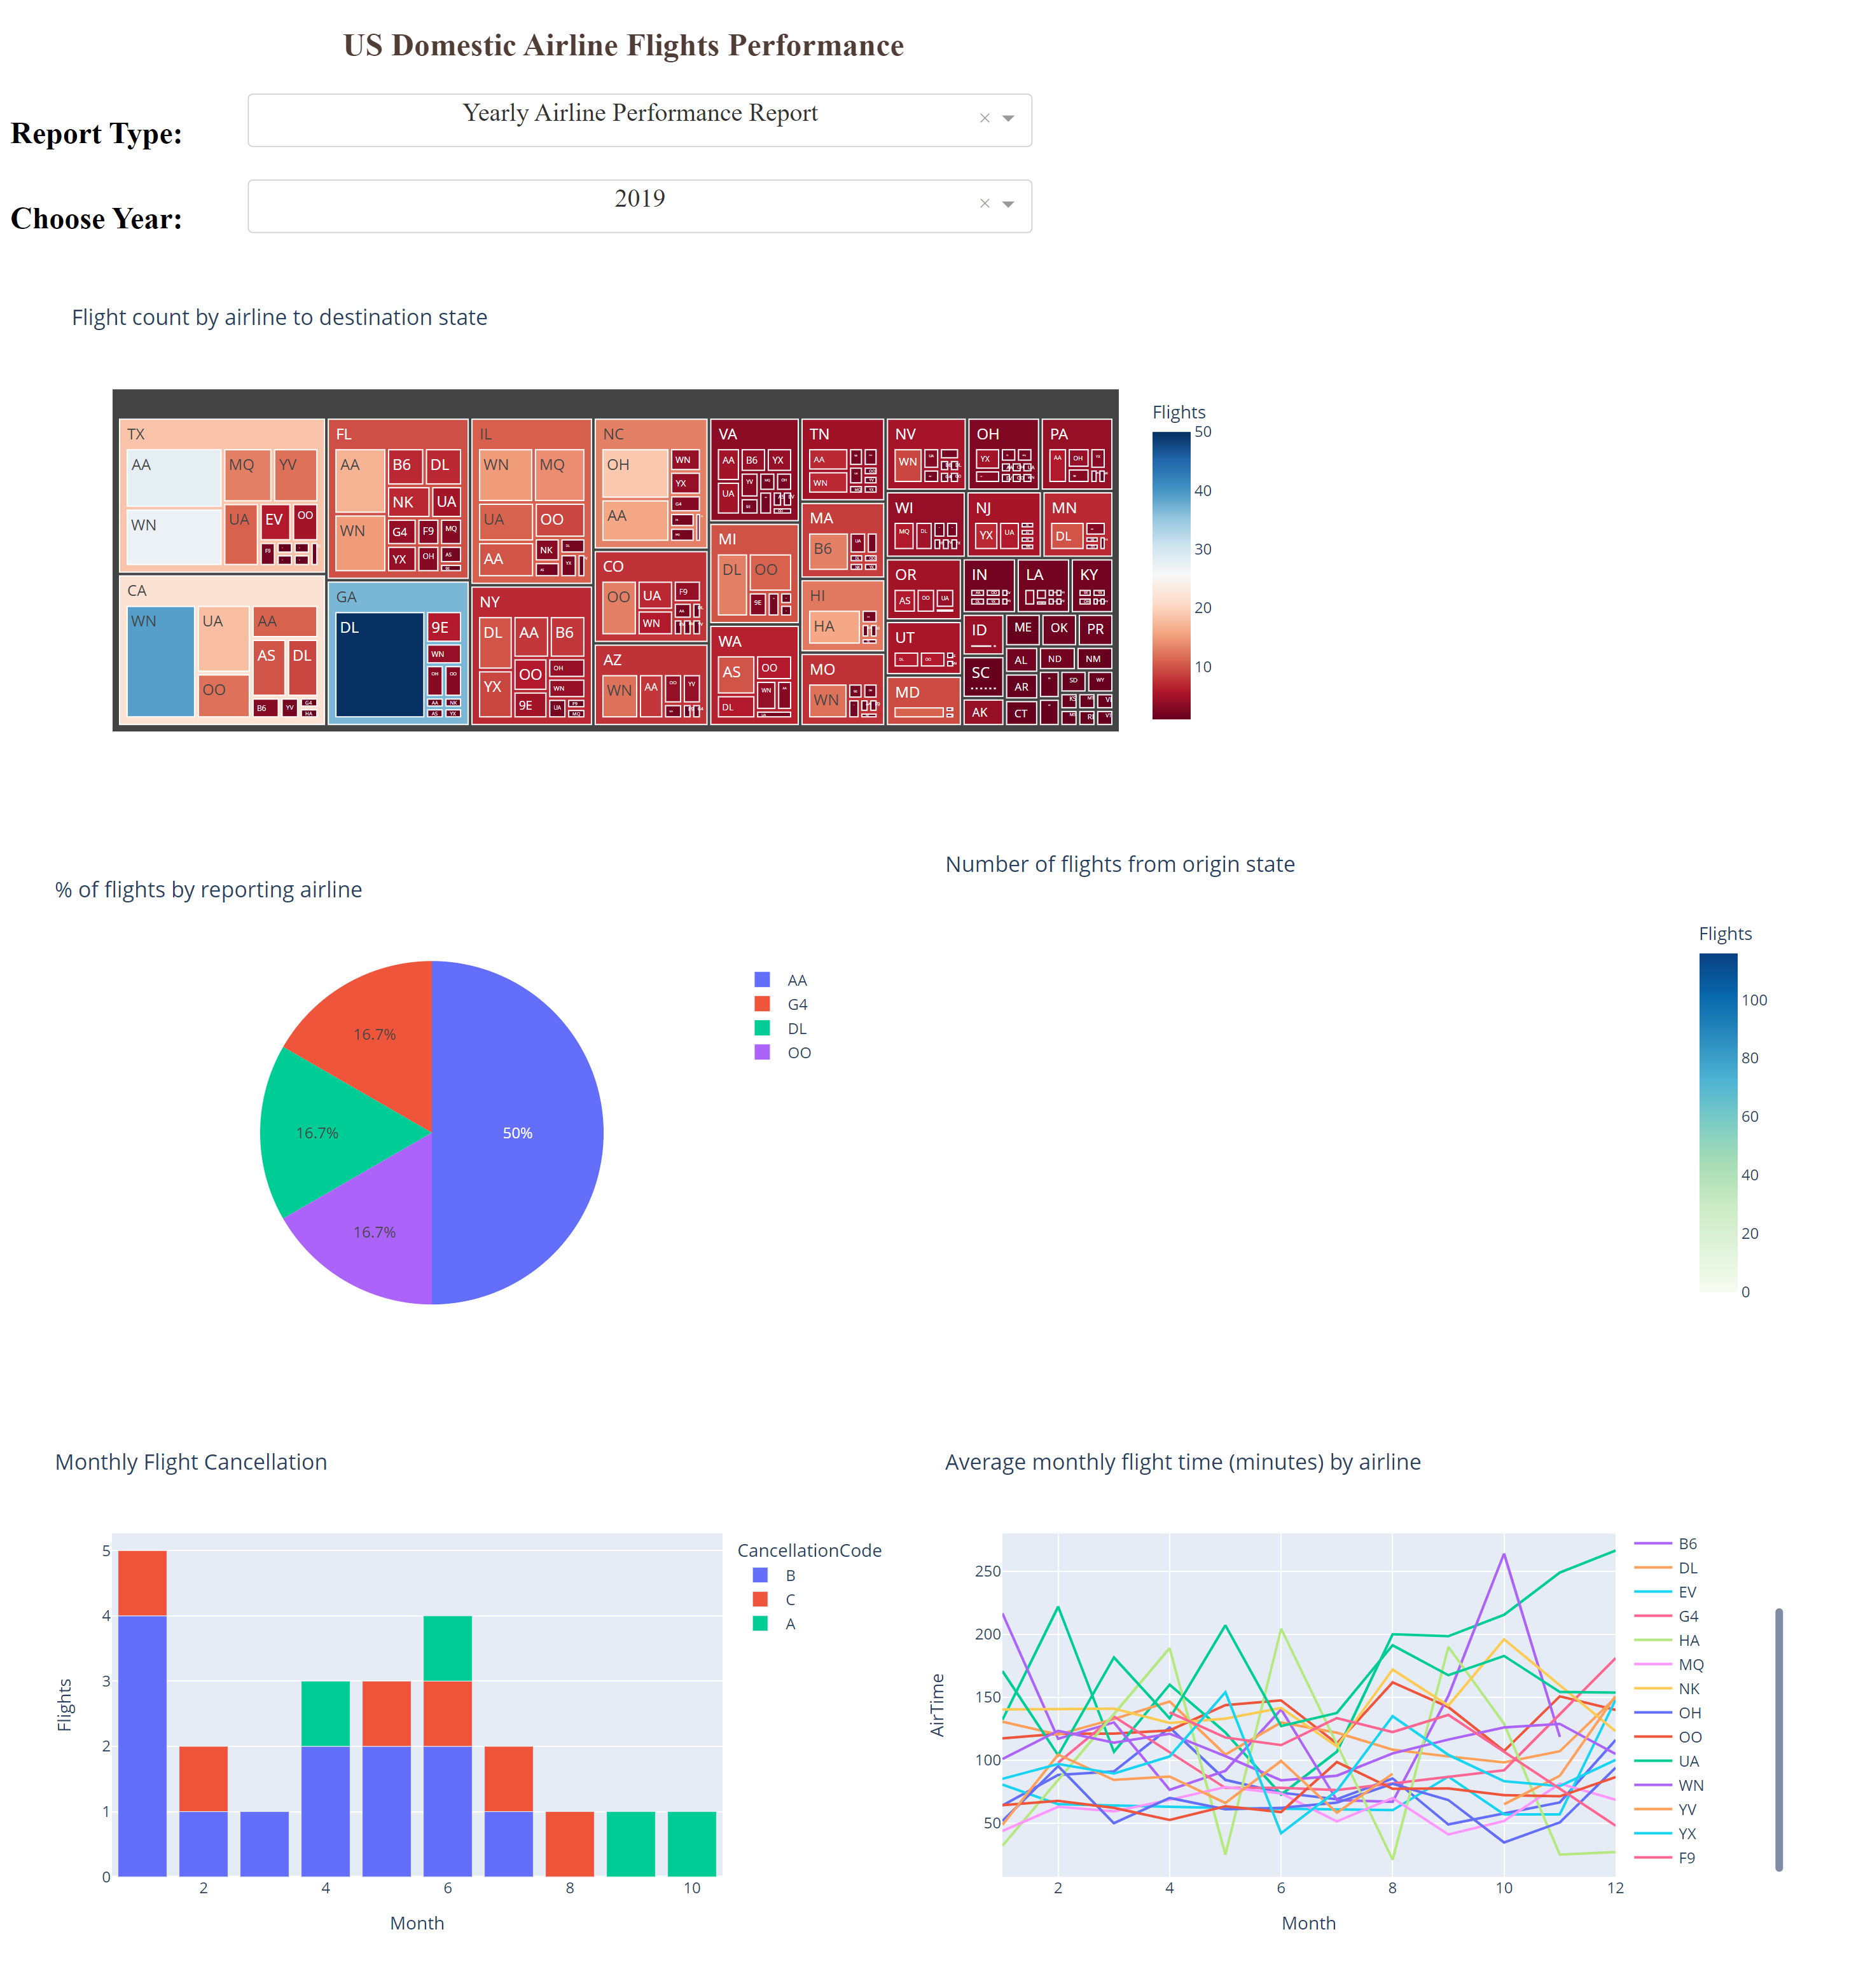

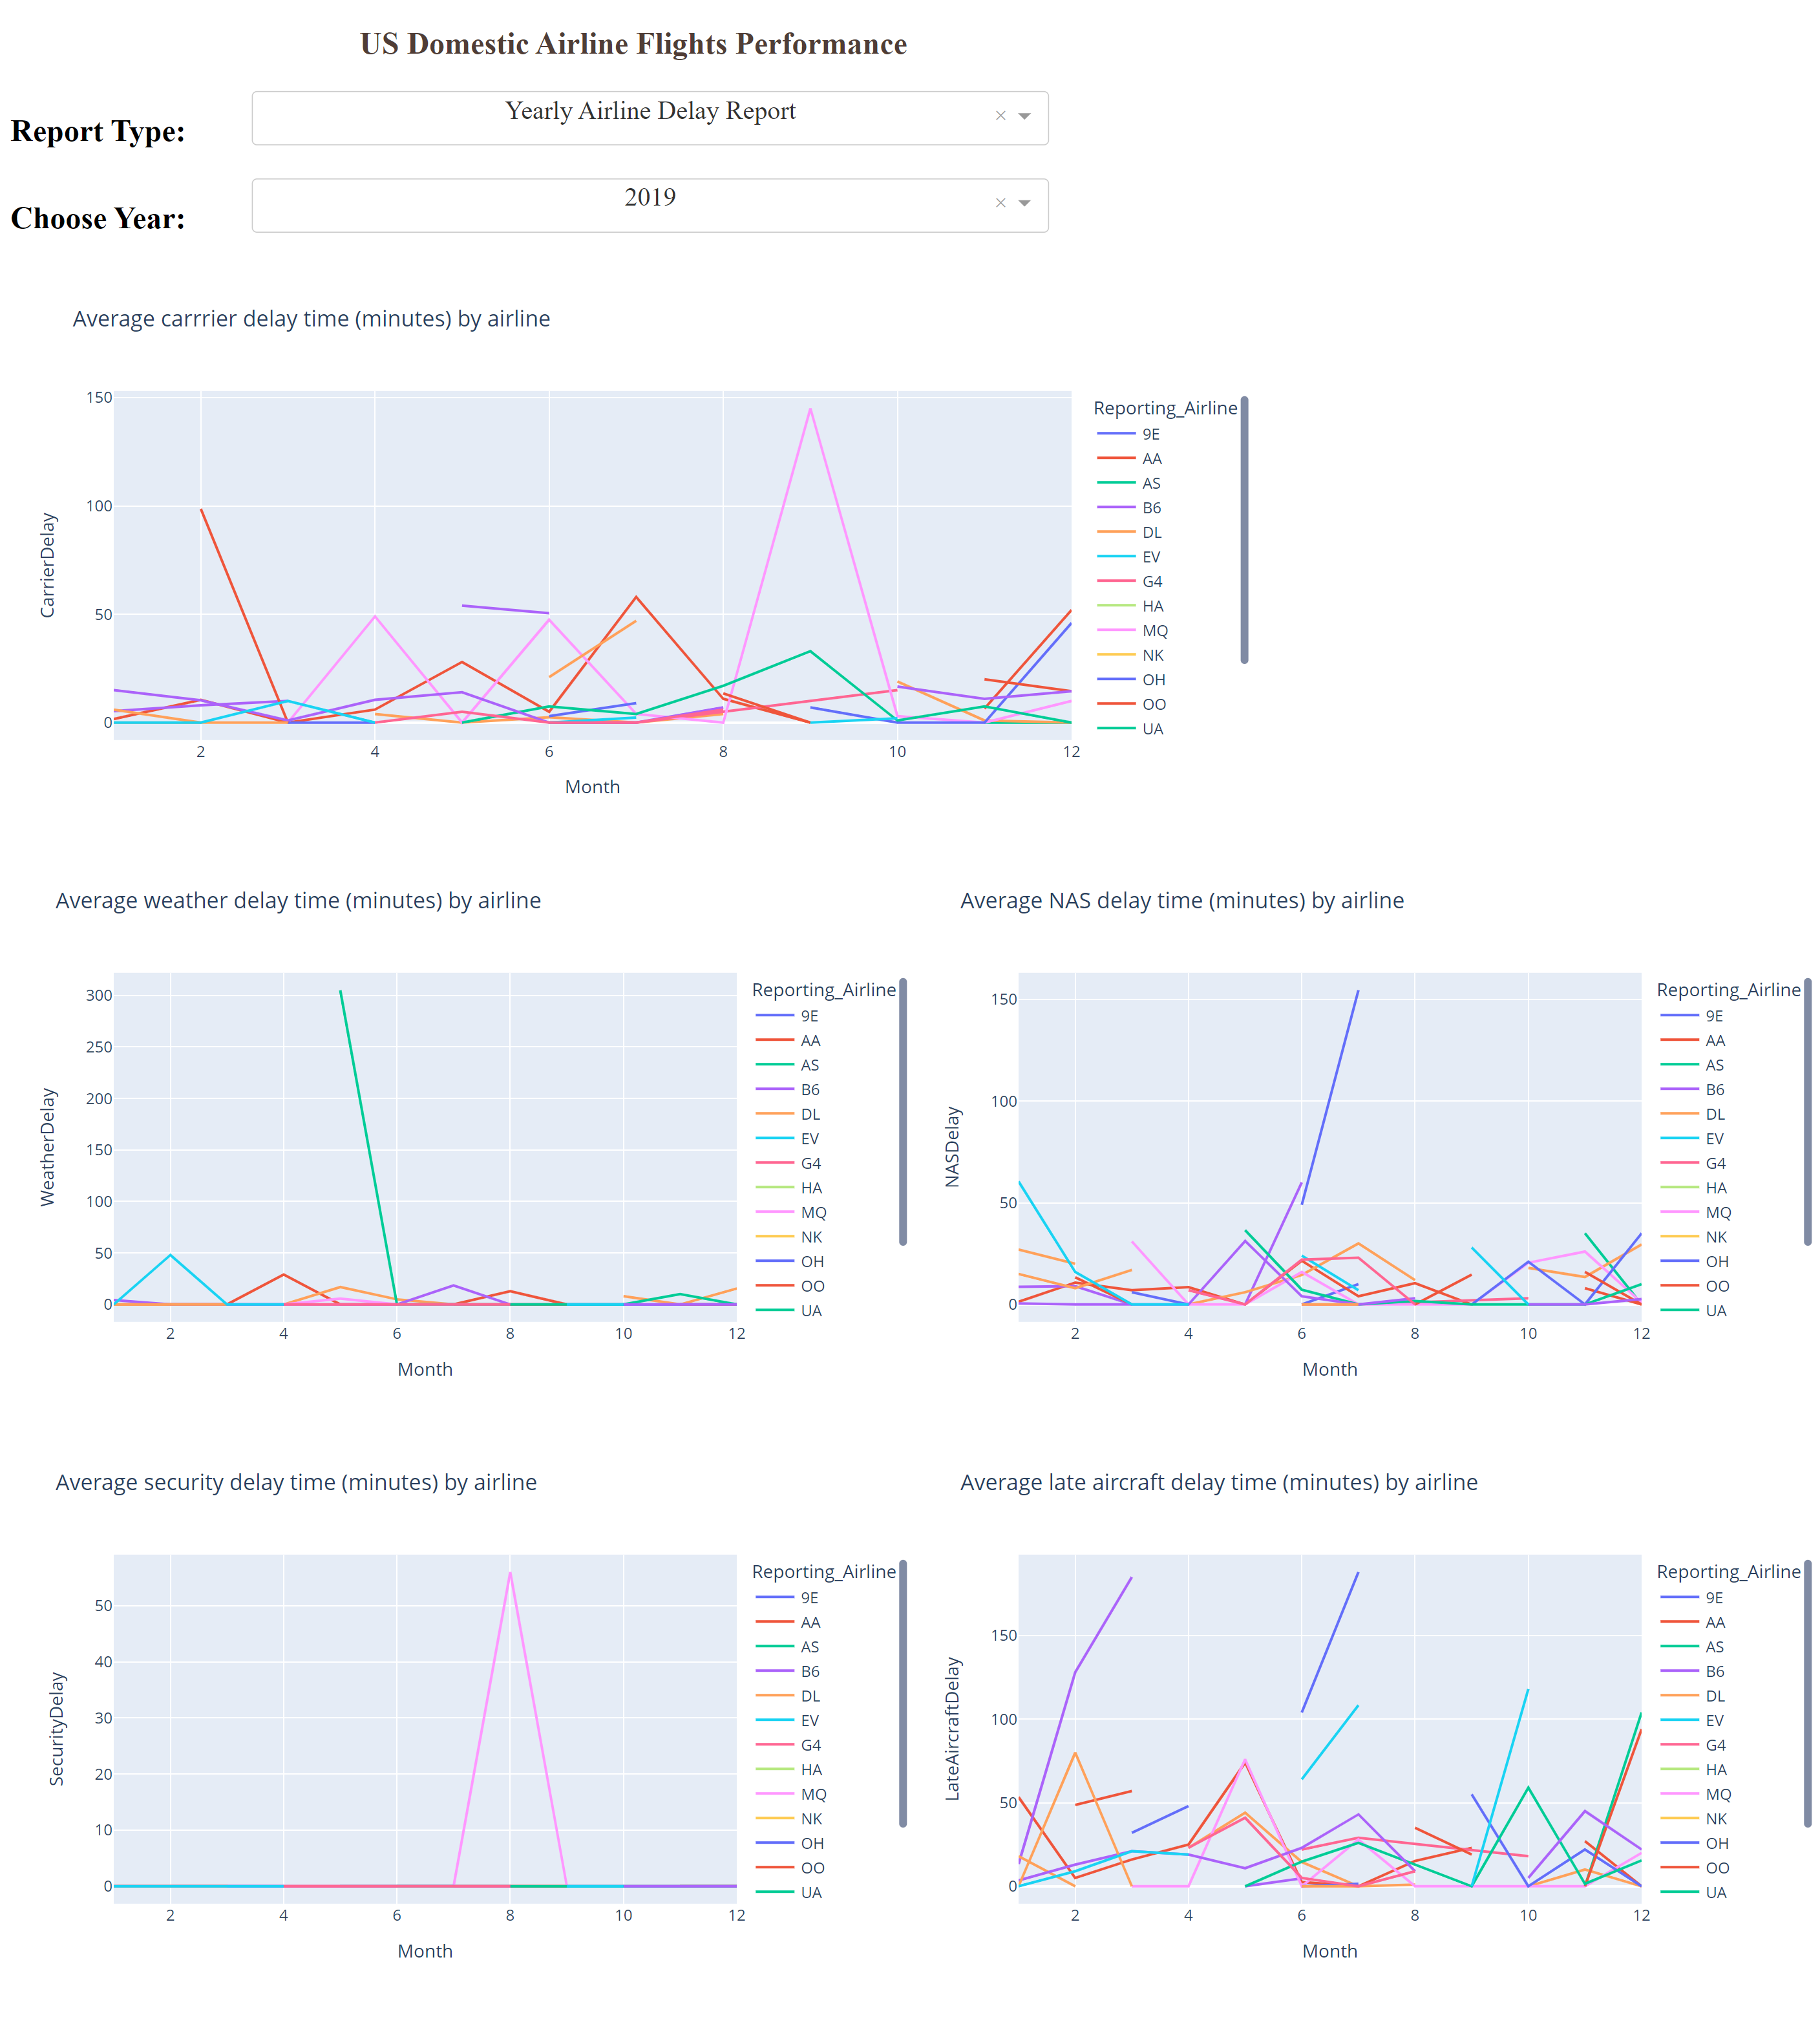

In [6]:
#View Dashboard
from PIL import Image 
img=Image.open('Fullsize screen shot.png')
img1=Image.open('Report.png')
display(img)
display(img1)